# Split

In [1]:
import os, random
from pathlib import Path

SRC_ROOT = Path.home() / "TBBR" / "train" / "images"
SUBSETS = ["Flug1_100", "Flug1_104"]
DEST_ROOT = Path.home() / "ProyectoFinalVA" / "img_splits"
EXT = ".npy"
SPLIT = (0.7, 0.2, 0.1)
SEED = 42

random.seed(SEED)
DEST_ROOT.mkdir(parents=True, exist_ok=True)

# 1) Recolectar todas las rutas .npy
paths = []
for sub in SUBSETS:
    folder = SRC_ROOT / sub
    if folder.exists():
        paths += list(folder.glob(f"*{EXT}"))

print(f"Total .npy encontrados: {len(paths)}")
paths = sorted(paths)
random.shuffle(paths)

# 2) Split
n = len(paths)
n_train = int(n * SPLIT[0])
n_val   = int(n * SPLIT[1])
splits = {
    "train": paths[:n_train],
    "val":   paths[n_train:n_train+n_val],
    "test":  paths[n_train+n_val:]
}

# 3) Escribir listas
for split, lst in splits.items():
    out = DEST_ROOT / f"{split}.txt"
    with open(out, "w") as f:
        for p in lst:
            f.write(str(p.resolve()) + "\n")
    print(f"{split}: {len(lst)} archivos")

print(f"Listas creadas en {DEST_ROOT} (train.txt, val.txt, test.txt)")


Total .npy encontrados: 696
train: 487 archivos
val: 139 archivos
test: 70 archivos
Listas creadas en /home/ignacio/ProyectoFinalVA/img_splits (train.txt, val.txt, test.txt)


In [2]:
import json
from pathlib import Path

# ========= CONFIG =========
BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"   # train.txt, val.txt, test.txt (rutas a .npy)
COCO_JSONS = [
    Path.home() / "TBBR" / "annotations_100.json",
    Path.home() / "TBBR" / "annotations_104.json",
]
OUT_DIR_JSON = BASE / "annotations_split"
WRITE_YOLO = True  # poné True si querés generar .txt YOLO
YOLO_OUT_ROOTS = {
    "train": BASE / "YOLO/HST/labels/train",  # cambiá si querés GST u otra ruta
    "val":   BASE / "YOLO/HST/labels/val",
    "test":  BASE / "YOLO/HST/labels/test",
}
# ==========================

def load_split_stems():
    """Lee train/val/test.txt y devuelve sets de 'stem' (nombre base del .npy)."""
    stems = {}
    for sp in ["train", "val", "test"]:
        txt = SPLITS_DIR / f"{sp}.txt"
        with open(txt) as f:
            files = [l.strip() for l in f if l.strip()]
        stems[sp] = {Path(p).stem for p in files}
    return stems

def load_coco(json_paths):
    """Fusiona múltiples COCO en un único dict COCO (images, annotations, categories)."""
    merged = {"images": [], "annotations": [], "categories": []}
    img_id_offset = 0
    ann_id_offset = 0
    # Unificar categorías por id (asumimos mismos ids/nombres entre archivos)
    cat_seen = {}
    for jp in json_paths:
        with open(jp) as f:
            d = json.load(f)
        # categories
        for c in d.get("categories", []):
            cid = c["id"]
            if cid not in cat_seen:
                cat_seen[cid] = c
    merged["categories"] = list(cat_seen.values())

    # images + annotations (conservalo tal cual los ids originales; no reindexamos)
    all_images = {}
    for jp in json_paths:
        with open(jp) as f:
            d = json.load(f)
        for im in d.get("images", []):
            all_images[im["id"]] = im
        for an in d.get("annotations", []):
            merged["annotations"].append(an)

    merged["images"] = list(all_images.values())
    return merged

def filter_coco_by_stems(coco, keep_stems):
    """Filtra COCO por el conjunto de stems (coincidencia por file_name.stem)."""
    # Seleccionar imágenes cuyo file_name (sin extensión) esté en keep_stems
    keep_img_ids = set()
    new_images = []
    for im in coco["images"]:
        stem = Path(im["file_name"]).stem
        if stem in keep_stems:
            keep_img_ids.add(im["id"])
            new_images.append(im)

    # Filtrar annotations por image_id
    new_anns = [a for a in coco["annotations"] if a["image_id"] in keep_img_ids]
    # Categories quedan igual (las que existen)
    return {"images": new_images, "annotations": new_anns, "categories": coco["categories"]}

def write_coco(path, coco_obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(coco_obj, f)

def write_yolo_labels_for_split(coco_split, out_dir):
    """Escribe .txt YOLO por imagen (formato: cls cx cy w h normalizados)."""
    out_dir.mkdir(parents=True, exist_ok=True)
    # Mapa img_id -> (W,H,stem)
    meta = {}
    for im in coco_split["images"]:
        W, H = im["width"], im["height"]
        stem = Path(im["file_name"]).stem
        meta[im["id"]] = (W, H, stem)

    # Agrupar annotations por image_id
    from collections import defaultdict
    by_img = defaultdict(list)
    for a in coco_split["annotations"]:
        by_img[a["image_id"]].append(a)

    for iid, anns in by_img.items():
        W, H, stem = meta[iid]
        lines = []
        for a in anns:
            cls = a["category_id"]  # asumimos índices de clase ya válidos 0..K-1 (si no, re-mapear)
            x, y, w, h = a["bbox"]  # COCO xywh (píxeles)
            cx = (x + w/2) / W
            cy = (y + h/2) / H
            ww = w / W
            hh = h / H
            cx = min(max(cx, 0.0), 1.0)
            cy = min(max(cy, 0.0), 1.0)
            ww = min(max(ww, 0.0), 1.0)
            hh = min(max(hh, 0.0), 1.0)
            lines.append(f"{cls} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")
        (out_dir / f"{stem}.txt").write_text("\n".join(lines) + ("\n" if lines else ""))

if __name__ == "__main__":
    stems_by_split = load_split_stems()
    coco = load_coco(COCO_JSONS)

    for sp in ["train", "val", "test"]:
        coco_sp = filter_coco_by_stems(coco, stems_by_split[sp])
        out_json = OUT_DIR_JSON / f"{sp}.json"
        write_coco(out_json, coco_sp)
        print(f"[{sp}] images={len(coco_sp['images'])} anns={len(coco_sp['annotations'])} -> {out_json}")

        if WRITE_YOLO:
            write_yolo_labels_for_split(coco_sp, YOLO_OUT_ROOTS[sp])
            print(f"[{sp}] YOLO .txt escritos en {YOLO_OUT_ROOTS[sp]}")


[train] images=420 anns=3343 -> /home/ignacio/ProyectoFinalVA/annotations_split/train.json
[train] YOLO .txt escritos en /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/train
[val] images=151 anns=1240 -> /home/ignacio/ProyectoFinalVA/annotations_split/val.json
[val] YOLO .txt escritos en /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/val
[test] images=84 anns=695 -> /home/ignacio/ProyectoFinalVA/annotations_split/test.json
[test] YOLO .txt escritos en /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/test


# Conversion a YOLO

In [ ]:
import os, cv2, numpy as np
from pathlib import Path
from tqdm import tqdm

# ================== CONFIG ==================
BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"                # train.txt / val.txt / test.txt (rutas a .npy)
MODE = "HST"                                # "HST" o "GST"
OUT_ROOT = BASE / f"YOLO/{MODE}"        # destino de imágenes y YOLO.yaml
LABELS_ROOT = OUT_ROOT / "labels"           # ya generadas (YOLO .txt)
IMAGES_ROOT = OUT_ROOT / "images"           # aquí se crearán PNGs
THERM_NORM = "per_image"                    # "per_image" o "global"
WRITE_YAML = True
CLASS_NAMES = None                          # ej: ["roof","window","wall"] o None si ya tenés YOLO.yaml
# ============================================

def ensure(p): Path(p).mkdir(parents=True, exist_ok=True)

def robust01(x, lo=1.0, hi=99.0):
    lo_v, hi_v = np.percentile(x, [lo, hi])
    x = np.clip(x, lo_v, hi_v)
    return (x - lo_v) / (hi_v - lo_v + 1e-9)

def to_uint8(x):
    return (np.clip(x, 0, 1) * 255).astype(np.uint8)

def load_list(txt_path: Path):
    with open(txt_path) as f:
        return [l.strip() for l in f if l.strip()]

def compute_global_therm_stats(train_list, band=3, max_files=2000):
    vals = []
    for p in tqdm(train_list[:max_files], desc="stats térmica (global)", ncols=90):
        arr = np.load(p)
        t = arr[..., band].astype(np.float32).ravel()
        t = t[np.isfinite(t)]
        if t.size:
            vals.append(t)
    if not vals:
        return 0.0, 1.0
    t_all = np.concatenate(vals)
    mu, std = float(np.mean(t_all)), float(np.std(t_all) + 1e-9)
    return mu, std

def write_yaml(root: Path, names):
    yml = f"""path: {root.resolve()}
train: images/train
val: images/val
test: images/test
names: {names if names is not None else []}
"""
    (root / "YOLO.yaml").write_text(yml)

def make_image_from_npy(npy_path: str, out_png: Path, mode: str, mu=None, std=None):
    """
    Crea PNG HST o GST a partir de un .npy con bandas:
      0-2: RGB, 3: Térmica, 4: (Depth, no usada)
    """
    arr = np.load(npy_path)
    if arr.ndim != 3 or arr.shape[-1] < 4:
        return False  # archivo inesperado

    rgb = arr[..., :3].astype(np.float32)
    t   = arr[..., 3].astype(np.float32)

    # Normalización robusta por canal para RGB → uint8
    rgb_min = np.percentile(rgb, 1, axis=(0,1))
    rgb_max = np.percentile(rgb, 99, axis=(0,1))
    rgb_n = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-9)
    rgb_u8 = to_uint8(rgb_n)

    # HSV / GRAY
    hsv = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2HSV)
    h, s, _ = cv2.split(hsv)
    gray = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2GRAY)

    # Normalización térmica
    if THERM_NORM == "per_image":
        t_n = robust01(t)
    else:
        t_n = (t - (mu or 0.0)) / ((std or 1.0))
        # reescala a 0..1 para guardar
        t_n = (t_n - t_n.min()) / (t_n.max() - t_n.min() + 1e-9)
    t_u8 = to_uint8(t_n)

    # Composición
    if mode.upper() == "HST":
        out = cv2.merge([h, s, t_u8])     # H,S,T
    else:
        out = cv2.merge([gray, s, t_u8])  # Gray,S,T

    ensure(out_png.parent)
    cv2.imwrite(str(out_png), out)
    return True

def main():
    # YAML (si no existe y pedís generarlo)
    if WRITE_YAML and not (OUT_ROOT / "YOLO.yaml").exists():
        write_yaml(OUT_ROOT, CLASS_NAMES)

    # Cargar listas
    split_files = {}
    for sp in ["train", "val", "test"]:
        p = SPLITS_DIR / f"{sp}.txt"
        if not p.exists():
            print(f"⚠️ Falta {p} — salto split {sp}")
            continue
        split_files[sp] = load_list(p)

    # Stats globales (opcional)
    mu = std = None
    if THERM_NORM == "global" and "train" in split_files:
        mu, std = compute_global_therm_stats(split_files["train"])

    # Procesar cada split
    for sp, npy_list in split_files.items():
        out_dir = IMAGES_ROOT / sp
        ensure(out_dir)
        # Si existen labels, los usamos para chequear nombres más adelante
        labels_dir = LABELS_ROOT / sp

        ok, bad = 0, 0
        for p in tqdm(npy_list, desc=f"{MODE} -> {sp}", ncols=90):
            stem = Path(p).stem
            out_name = f"{stem}.png"   # coincide con .txt: <stem>_<MODE>.txt
            out_png = out_dir / out_name
            if out_png.exists():  # evitar recomputar
                ok += 1
                continue
            if make_image_from_npy(p, out_png, MODE, mu, std):
                ok += 1
            else:
                bad += 1

        print(f"[{sp}] generadas: {ok}, fallidas: {bad}")

                # Verificación rápida con labels (si existen)
        # Verificación rápida con labels (si existen)
        if labels_dir.exists():
            # normalización robusta de stems
            def norm(s: str) -> str:
                s = s.strip()
                for suf in ("_HST", "_GST", "_hst", "_gst"):
                    if s.endswith(suf):
                        return s[: -len(suf)]
                return s

            imgs = {norm(q.stem) for q in out_dir.glob("*.png")}
            labs = {norm(q.stem) for q in labels_dir.glob("*.txt")}

            # 1) Crear primero los .txt vacíos para los que falten
            faltan = sorted(list(imgs - labs))
            for stem in faltan:
                (labels_dir / f"{stem}_{MODE}.txt").touch()
            if faltan:
                print(f"[{sp}] creados {len(faltan)} .txt vacíos (para negativos).")

            # 2) Recalcular sets y reportar estado final (ya sin falsos warnings)
            labs = {norm(q.stem) for q in labels_dir.glob("*.txt")}
            faltan_txt = sorted(list(imgs - labs))[:10]
            faltan_img = sorted(list(labs - imgs))[:10]

            if faltan_txt:
                print(f"⚠️ En {sp}: hay imágenes sin .txt (primeros 10): {faltan_txt}")
            if faltan_img:
                print(f"⚠️ En {sp}: hay .txt sin imagen (primeros 10): {faltan_img}")
            if not faltan_txt and not faltan_img:
                print(f"[{sp}] ✔ imágenes y labels matchean por nombre base.")


    print(f"✅ Listo. PNGs {MODE} en: {IMAGES_ROOT}  |  Labels: {LABELS_ROOT}")
    if WRITE_YAML:
        print(f"YAML: {OUT_ROOT/'YOLO.yaml'}")

if __name__ == "__main__":
    main()


HST -> train: 100%|█████████████████████████████████████| 487/487 [10:53<00:00,  1.34s/it]


[train] generadas: 487, fallidas: 0
⚠️ En train: hay imágenes sin .txt (primeros 10): ['DJI_0003_R', 'DJI_0005_R', 'DJI_0007_R', 'DJI_0009_R', 'DJI_0013_R', 'DJI_0017_R', 'DJI_0019_R', 'DJI_0021_R', 'DJI_0023_R', 'DJI_0025_R']
[train] creados 74 .txt vacíos (para negativos).


HST -> val: 100%|███████████████████████████████████████| 139/139 [05:03<00:00,  2.19s/it]


[val] generadas: 139, fallidas: 0
[val] ✔ imágenes y labels matchean por nombre base.


HST -> test: 100%|████████████████████████████████████████| 70/70 [02:37<00:00,  2.26s/it]

[test] generadas: 70, fallidas: 0
⚠️ En test: hay imágenes sin .txt (primeros 10): ['DJI_0011_R', 'DJI_0045_R', 'DJI_0051_R', 'DJI_0055_R', 'DJI_0071_R', 'DJI_0081_R', 'DJI_0293_R']
[test] creados 7 .txt vacíos (para negativos).
✅ Listo. PNGs HST en: /home/ignacio/ProyectoFinalVA/YOLO/HST/images  |  Labels: /home/ignacio/ProyectoFinalVA/YOLO/HST/labels
YAML: /home/ignacio/ProyectoFinalVA/YOLO/HST/YOLO.yaml


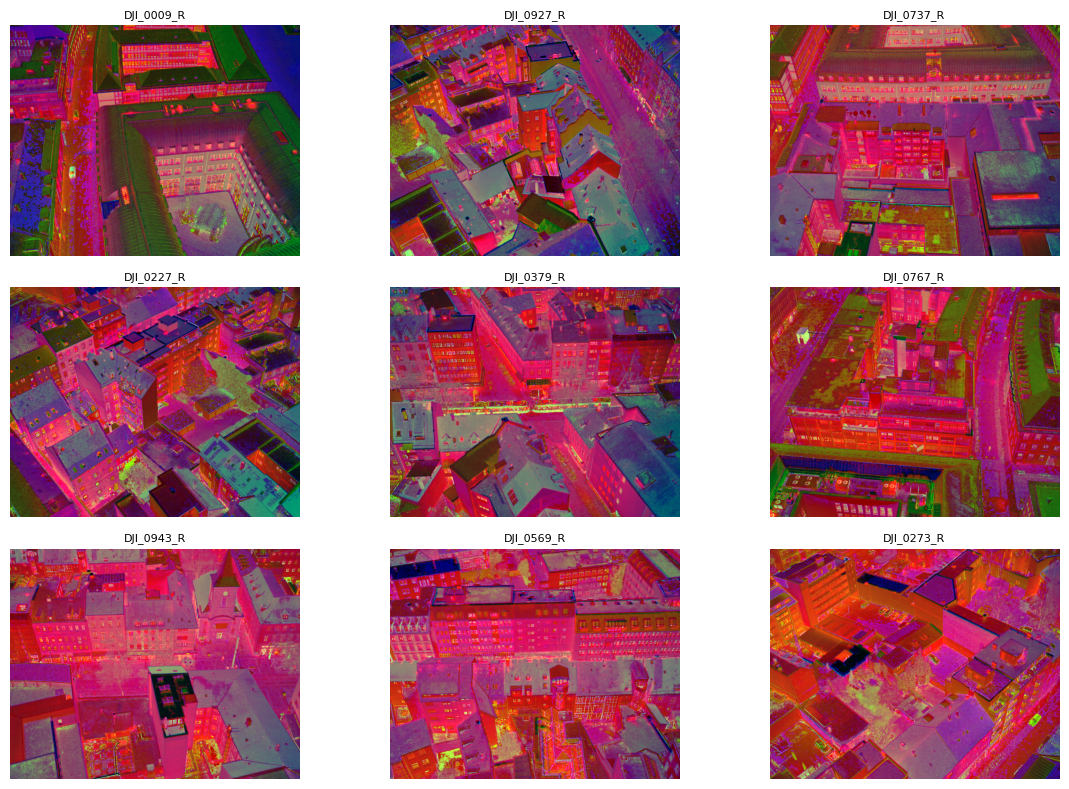

In [4]:
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# === Configuración ===
BASE = Path.home() / "ProyectoFinalVA"
MODE = "HST"                # "HST" o "GST"
IMAGES_DIR = BASE / f"YOLO/{MODE}/images/train"
N = 9                       # número de imágenes a mostrar

# === Seleccionar algunas imágenes aleatorias ===
imgs = list(IMAGES_DIR.glob("*.png"))
sample = random.sample(imgs, min(N, len(imgs)))

# === Mostrar ===
cols = 3
rows = (len(sample) + cols - 1) // cols
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(sample):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(img_path.stem, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()
